In [1]:
import numpy as np
import matplotlib.pyplot as plt

from phaseunwrapping import wrap_function, mle_1d
from phaseunwrapping import build_1d_first_order_grad, build_1d_second_order_grad

In [2]:

def tikhonov_1d(psi, R, reg_lambda=1.0, weights=None):
    """Given a 1D wrapped phase vector psi, computes the MLE estimator corresponding to the D2 data fidelity term.
    
    psi: the wrapped phase.
    R: regularization operator
    reg_lambda: the regularization parameter (controls strength).
    weights: weighint for the D2 penalty function.

    """

    # Figure out shape
    n = len(psi)

    # Build F matrix
    F = build_1d_first_order_grad(n, boundary="none")

    # Make $\phi_1$
    phi1 = np.zeros(n)
    phi1[0] = psi[0]

    # Build the undersampling matrix
    P = np.eye(n)[1:,:].T

    # Set initial weights
    if weights is None:
        weights = np.ones(F.shape[0])
    else:
        assert len(weights) == len(psi), "psi and weight vector must have same length!"

    # rhs vector
    rhs = P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psi) - (F @ phi1) )

    # Q matrix
    Q = P.T @ F.T @ np.diag(weights) @ F @ P   # data fidelity contribution
    Q = Q + reg_lambda*(R.T @ R)

    # Solve system for answer
    phi2 = np.linalg.solve(Q, rhs)

    # Append first entry
    reconstructed_phi = np.zeros(n)
    reconstructed_phi[1:] = phi2
    reconstructed_phi[0] = psi[0]

    return reconstructed_phi
    


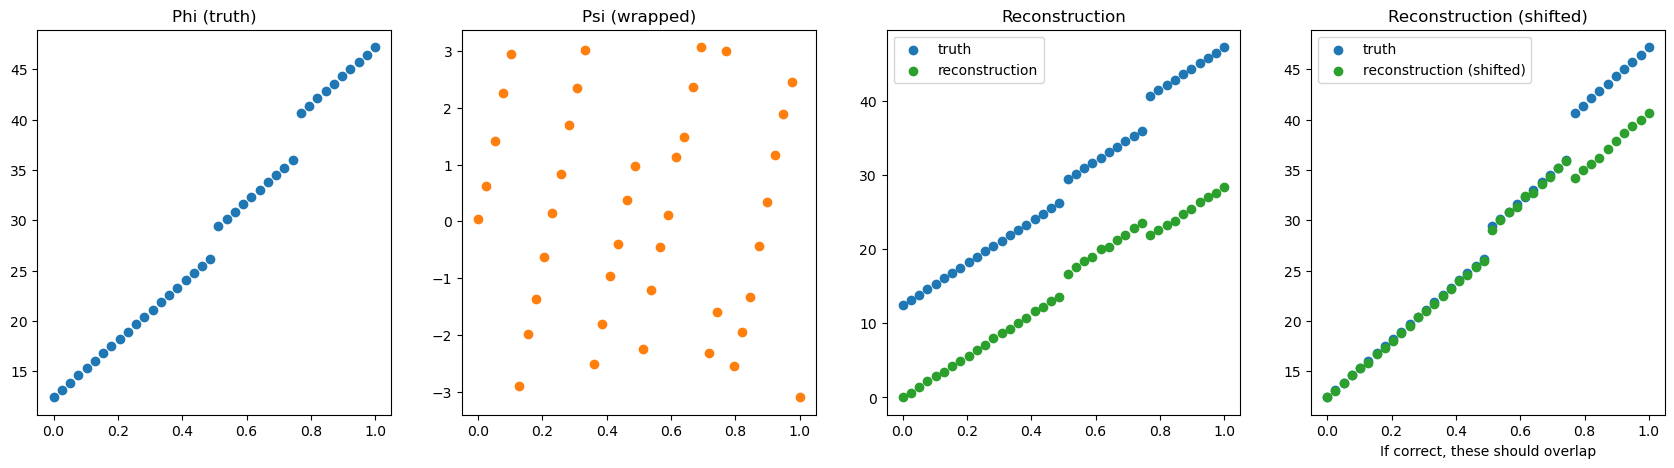

In [3]:
# Make test phase
N = 40
phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
phi[20:] += 2.5
phi[30:] += 4
grid = np.linspace(0,1,N)
noise_sigma = 0.1

# Wrap it
np.random.seed(0)
psi = wrap_function(phi) + noise_sigma*np.random.normal(size=len(phi))

# Unwrapping algorithm
reconstructed_phi = mle_1d(psi)


# Plot results
fig, axs = plt.subplots(1,4,figsize=(21,5))

axs[0].scatter(grid, phi, color="C0")
axs[1].scatter(grid, psi, color="C1")
axs[0].set_title("Phi (truth)")
axs[1].set_title("Psi (wrapped)")

axs[2].scatter(grid, phi, label="truth", color="C0")
axs[2].scatter(grid, reconstructed_phi, label="reconstruction", color="C2")
axs[2].legend()
axs[2].set_title("Reconstruction")


axs[3].scatter(grid, phi, label="truth", color="C0")
axs[3].scatter(grid, reconstructed_phi + (phi[0] - reconstructed_phi[0]), label="reconstruction (shifted)", color="C2")
axs[3].legend()
axs[3].set_title("Reconstruction (shifted)")
axs[3].set_xlabel("If correct, these should overlap")


plt.show()

In [4]:
# R = build_1d_first_order_grad(N-1)
R = build_1d_second_order_grad(N-1)

In [5]:
tikhonov_1d(psi, R, reg_lambda=1.0, weights=None)

array([ 0.03481258,  0.62340599,  1.40281009,  2.17877728,  2.87607634,
        3.50435691,  4.25140024,  4.9465301 ,  5.67003799,  6.41563504,
        7.15255366,  7.91938502,  8.6269546 ,  9.3271726 , 10.05921041,
       10.79790407, 11.56798323, 12.29850363, 13.16492652, 14.25686924,
       16.05800794, 17.31438782, 18.23674498, 19.00137193, 19.80857279,
       20.43937355, 21.17200407, 21.86409954, 22.50606676, 22.84289371,
       22.49276646, 22.79520128, 23.30532857, 23.93488751, 24.69775521,
       25.46852803, 26.24256972, 26.96154492, 27.62223696, 28.31932565])

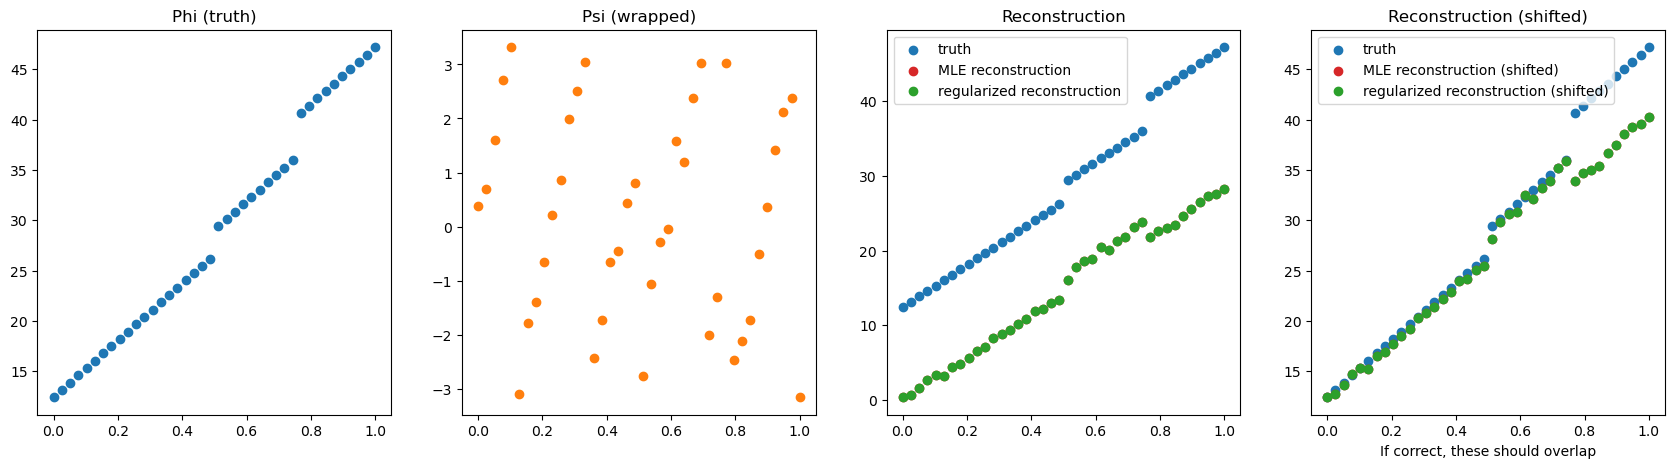

In [12]:
# Make test phase
N = 40
phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
phi[20:] += 2.5
phi[30:] += 4
grid = np.linspace(0,1,N)
noise_sigma = 0.3
reg_lambda = 1e-5

# Wrap it
np.random.seed(0)
psi = wrap_function(phi) + noise_sigma*np.random.normal(size=len(phi))

# Unwrapping algorithm
mle_phi = mle_1d(psi)
reconstructed_phi = tikhonov_1d(psi, R, reg_lambda=reg_lambda, weights=None)


# Plot results
fig, axs = plt.subplots(1,4,figsize=(21,5))

axs[0].scatter(grid, phi, color="C0")
axs[1].scatter(grid, psi, color="C1")
axs[0].set_title("Phi (truth)")
axs[1].set_title("Psi (wrapped)")

axs[2].scatter(grid, phi, label="truth", color="C0")
axs[2].scatter(grid, mle_phi, label="MLE reconstruction", color="C3")
axs[2].scatter(grid, reconstructed_phi, label="regularized reconstruction", color="C2")
axs[2].legend()
axs[2].set_title("Reconstruction")


axs[3].scatter(grid, phi, label="truth", color="C0")
axs[3].scatter(grid, mle_phi + (phi[0] - mle_phi[0]), label="MLE reconstruction (shifted)", color="C3")
axs[3].scatter(grid, reconstructed_phi + (phi[0] - reconstructed_phi[0]), label="regularized reconstruction (shifted)", color="C2")
axs[3].legend()
axs[3].set_title("Reconstruction (shifted)")
axs[3].set_xlabel("If correct, these should overlap")


plt.show()

In [28]:
import scipy.sparse as sps

In [44]:
def build_1d_second_order_grad(N, boundary="none"):
    """Constructs a SciPy sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions.
    """
    
    assert boundary in ["none", "zero", "periodic"], "Invalid boundary parameter."
    
    d_mat = -2*sps.eye(N)
    d_mat.setdiag(1,k=-1)
    d_mat.setdiag(1,k=1)
    d_mat = d_mat.tolil()
    
    if boundary == "none":
        d_mat = d_mat[1:-1,:]
    elif boundary == "zero":
        pass
    elif boundary == "periodic":
        d_mat[0,-1] = 1
        d_mat[-1,0] = 1
    else:
        raise NotImplementedError

    return d_mat


In [47]:
build_1d_second_order_grad(5, boundary="periodic").toarray()

array([[-2.,  1.,  0.,  0.,  1.],
       [ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.],
       [ 1.,  0.,  0.,  1., -2.]])

In [40]:
N = 5
d_mat = -2*sps.eye(N)
d_mat.setdiag(1,k=-1)
d_mat.setdiag(1,k=1)
d_mat = d_mat.tolil()

    

In [41]:
d_mat.toarray()

array([[-2.,  1.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  1., -2.]])